#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import diffusion_utils

import networkx as nx

from copy import deepcopy

from tqdm import tqdm

import random

from itertools import combinations

In [30]:
import importlib
importlib.reload(diffusion_utils)

<module 'diffusion_utils' from '/Users/oseckin/Documents/GitHub/belief_network_extended/notebooks/../scripts/diffusion_utils.py'>

## Star Network Belief Systems

#### Create the social network

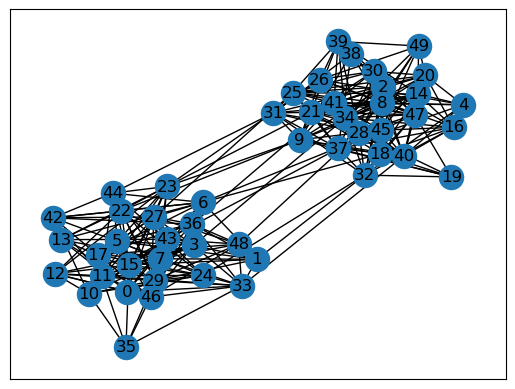

In [2]:
N = 50
M = 300
mu = .05

social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

nx.draw_networkx(social_G)

#### Generate and embed the belief networks inside the social network

In [169]:
social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

#### Random walk to close triads

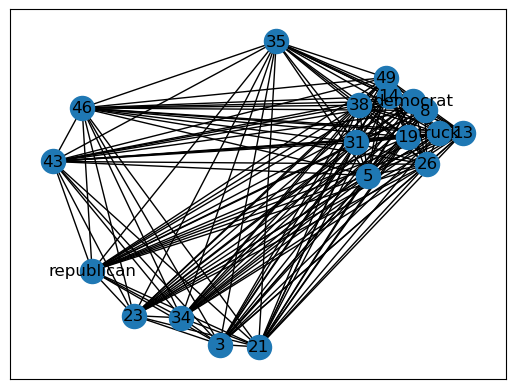

In [170]:
g = social_G.nodes[8]['belief_network']

nx.draw_networkx(g)

In [171]:
del g

In [3]:
def get_avg_measures(social_G):
    
    temp1 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    temp2 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    for e in social_G.edges():
        w1 = social_G.nodes[e[0]]['belief_network'].edges[e]['weight']
        w2 = social_G.nodes[e[1]]['belief_network'].edges[e]['weight']

        diff = abs(w1 - w2)
        comm1 = communities[e[0]] + "s"
        comm2 = communities[e[1]] + "s"
        
        if comm1 != comm2:
            temp1['inter-group'].append(diff)
            temp2['inter-group'].append(w1)
            temp2['inter-group'].append(w2)
        else:
            temp1['intra-group'].append(diff)
            temp2['intra-group'].append(w1)
            temp2['intra-group'].append(w2)
        
        temp1['aggregate'].append(diff)
        temp2['aggregate'].append(w1)
        temp2['aggregate'].append(w2)
    
    return temp1, temp2

In [4]:
def random_walker_detailed(g, focal_edge):
    
    node_order = list(g.nodes())
    #print("Node Order:", node_order)

    # Create mappings
    index_to_node = {i: node for i, node in enumerate(node_order)}
    node_to_index = {node: i for i, node in enumerate(node_order)}
    
    # get the adjacency matrix
    adj = nx.adjacency_matrix(g)

    # take the absolute value of all
    abs_adj = abs(adj)

    # sum of columns will be used to normalize the values
    normalizer = abs_adj.sum(axis=0)

    # normalize the values columnwise
    abs_adj_normalized = abs_adj/normalizer

    # probabilities for a two-step random walk
    random_walk_probs = (abs_adj_normalized**2).todense()

    # choose one of the nodes from the edge as the starter node
    i = np.random.choice([0,1])
    starting_node = focal_edge[i]
    middle_node = focal_edge[i-1]

    # determine the column number of the middle node in the adj matrix
    col = node_to_index[middle_node]

    # extract the probabilities that starting from the starter node,
    # what are the probabilities ending up in the other nodes in k jumps?
    probabilities = random_walk_probs[:,col].flatten()

    # choose a node depending on the probabilities
    ending_node = random.choices(node_order, weights=probabilities, k=1)[0]

    return starting_node, middle_node, ending_node

In [ ]:
def random_walker(g, focal_edge):
    
    node_order = list(g.nodes())
    #print("Node Order:", node_order)

    # Create mappings
    index_to_node = {i: node for i, node in enumerate(node_order)}
    node_to_index = {node: i for i, node in enumerate(node_order)}
    
    # get the adjacency matrix
    adj = nx.adjacency_matrix(g)

    # take the absolute value of all
    abs_adj = abs(adj)

    # sum of columns will be used to normalize the values
    normalizer = abs_adj.sum(axis=0)

    # normalize the values columnwise
    abs_adj_normalized = abs_adj/normalizer

    # probabilities for a two-step random walk
    random_walk_probs = (abs_adj_normalized**2).todense()

    # choose one of the nodes from the edge as the starter node
    i = np.random.choice([0,1])
    starting_node = focal_edge[i]
    middle_node = focal_edge[i-1]

    # determine the column number of the middle node in the adj matrix
    col = node_to_index[middle_node]

    # extract the probabilities that starting from the starter node,
    # what are the probabilities ending up in the other nodes in k jumps?
    probabilities = random_walk_probs[:,col].flatten()

    # choose a node depending on the probabilities
    ending_node = random.choices(node_order, weights=probabilities, k=1)[0]

    return starting_node, middle_node, ending_node

In [5]:
def assign_weight_to_new_edge(g, starting_node, middle_node, ending_node):
    
    # compute the multiplication of starting to middle and middle to ending node edges
    curr_multiplication = g.edges[(starting_node, middle_node)]['weight'] * g.edges[(middle_node, ending_node)]['weight']
    
    # assign a random initial weight drawn from normal distribution that ensures cognitive
    # consonance for the triad

    dissonant = True

    while dissonant:
        initial_weight = np.random.normal(0, .2)
        if curr_multiplication * initial_weight < 0:
            dissonant = False
    
    return initial_weight

In [26]:
beta = 1

N = 30
M = 100
mu = .05

networks = {1:{}, 1.5:{}, 3:{}, 5:{}}
log = {1:{}, 1.5:{}, 3:{}, 5:{}}

for alpha in [1, 1.5, 3, 5]:
    for sim in range(10):

        # initialize the social network
        social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)
        
        networks[alpha][sim] = {}
        networks[alpha][sim]['start'] = deepcopy(social_G)

        # embed the belief networks into social networks
        social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

        #networks[0] = deepcopy(social_G)

        avg_diff = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
        avg_w = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

        T = N * 600

        for t in tqdm(range(T+1)):

            # Randomly choose a sender, receiver and focal edge
            sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_focal_edge(social_G)

            # Receiver's belief about democrat or republican cannot be changed 
            cond1 = frozenset(focal_edge) != frozenset(('republican', receiver))
            cond2 = frozenset(focal_edge) != frozenset(('democrat', receiver))

            # if the edge does not exist at all in the receiver's belief system, we don't update
            cond3 = not social_G.nodes[receiver]['belief_network'].has_edge(focal_edge[0],focal_edge[1])

            # if the edge is not in receiver's belief system at all, skip the step
            if cond3:
                continue

            # if none of these hold, do the update
            elif cond1 & cond2:

                # Calculate the updated weight after agents interact
                b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender, receiver, 
                                                                      focal_edge, alpha=alpha, beta=beta)

                # Update the belief in the network
                diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                                   b_i_plus_1)

            # RANDOM WALK
            # Extract the receiver's belief network
            g = social_G.nodes[receiver]['belief_network']

            # Agent thinks to themselves after updating their belief (apply random walk)
            starting_node, middle_node, ending_node = random_walker(g, focal_edge)

            if (starting_node == ending_node):
                # If starting node is the same as the ending node, take the middle node
                focal_edge = (starting_node, middle_node)

            elif g.has_edge(starting_node, ending_node):
                focal_edge = (starting_node, ending_node)

            # Receiver's belief about democrat or republican cannot be changed 
            cond1 = frozenset(focal_edge) != frozenset(('republican', receiver))
            cond2 = frozenset(focal_edge) != frozenset(('democrat', receiver))

            if cond1 & cond2:
                b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender=None, receiver=receiver, 
                                                                      focal_edge=focal_edge, alpha=alpha, beta=beta)

                # Update the belief in the network
                diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, 
                                                                   b_i_plus_1)


            temp1, temp2 = get_avg_measures(social_G)

            for k,v in temp1.items():
                avg_diff[k].append(np.mean(v))

            for k,v in temp2.items():
                avg_w[k].append(np.mean(v))

        networks[alpha][sim]['end'] = deepcopy(social_G)

        log[alpha][sim] = {}
        log[alpha][sim]['avg_diff'] = avg_diff
        log[alpha][sim]['avg_w'] = avg_w

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18001/18001 [21:05<00:00, 14.23it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18001/18001 [05:45<00:00, 52.11it/s]


In [27]:
import json
with open('../data/random_walk_2024_10_08/data.json', 'w') as f:
    json.dump(log, f)

In [16]:
receiver

9

Community: republican
Weight toward republican: {'weight': 1}
Weight toward democrat: {'weight': -1}


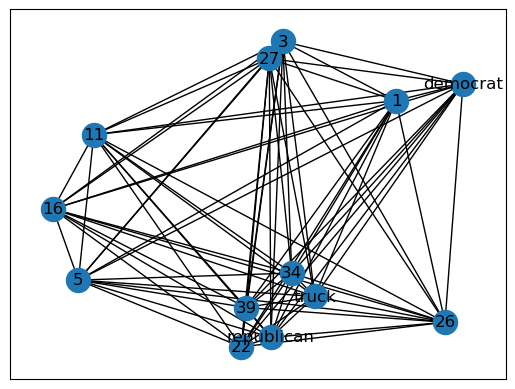

In [21]:
node = 22
nx.draw_networkx(social_G.nodes[node]['belief_network'])

print("Community:", communities[node])

print("Weight toward republican:", social_G.nodes[node]['belief_network'].edges[(node,'republican')])
print("Weight toward democrat:", social_G.nodes[node]['belief_network'].edges[(node,'democrat')])

In [22]:
node = 5
print("Community:", communities[node])

# find neighbors and select one
neighbor = random.choice([*social_G.neighbors(node)])
print(neighbor)
communities[neighbor]

Community: republican
39


'republican'

In [37]:
alpha = 1
[len(v[d][l]) for v in log[alpha].values()]

[8871, 8673, 9161, 9077, 7929, 8726, 7861, 9053, 8359, 9856]

/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_76677/3555007624.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


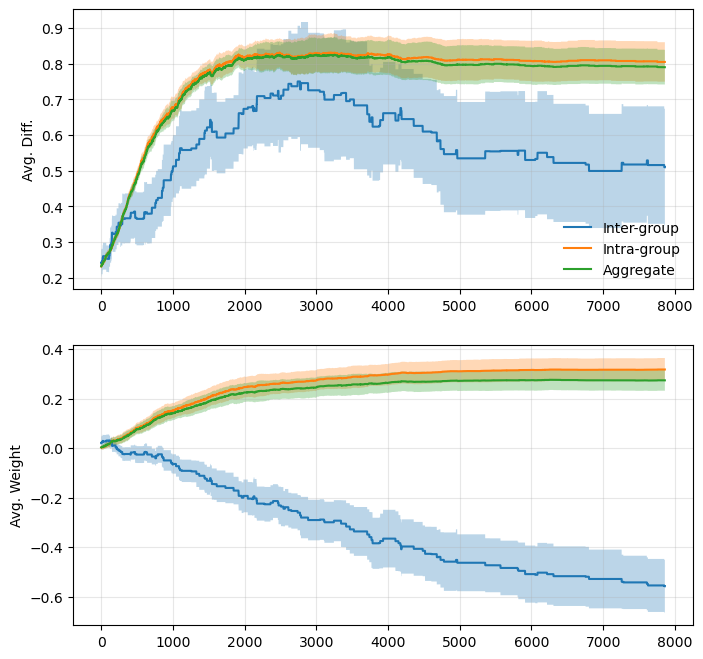

In [38]:
fig, axs = plt.subplots(2,1,figsize=(8,8))

for i, d, ylabel in zip([0,1], ['avg_diff', 'avg_w'], ['Avg. Diff.', 'Avg. Weight']):
    for l in ['inter-group', 'intra-group', 'aggregate']:
        avg = np.mean([v[d][l][:7861] for v in log[alpha].values()], axis=0)
        std = np.std([v[d][l][:7861] for v in log[alpha].values()], axis=0)
        axs[i].plot(avg, 
                    label=l.capitalize())
        
        axs[i].fill_between(range(len(avg)),
                            avg+(std/2), avg-(std/2),
                            alpha=.3)
    
    axs[i].set_ylabel(ylabel)
    axs[i].grid(alpha=.3)
    
axs[0].legend(frameon=False)

fig.show()

In [77]:
alpha = 3
G = networks[alpha][5]['end']

(array([8., 0., 0., 0., 1., 0., 0., 0., 0., 6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

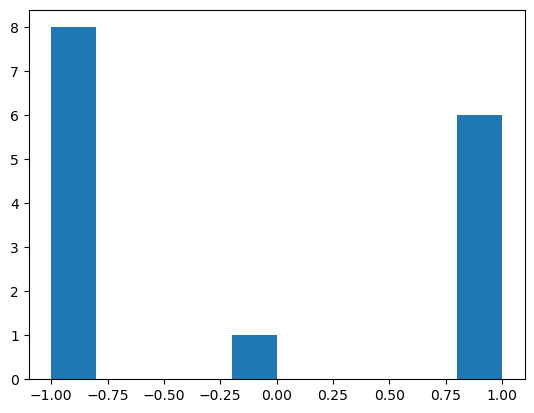

In [78]:
plt.hist([G.nodes[n]['belief_network'].edges[(n,'truck')]['weight'] for n in G.nodes if G.nodes[n]['belief_network'].edges[(n,'democrat')]['weight']==1])

In [ ]:
plt.hist([G.nodes[n]['belief_network'].edges[(n,'truck')]['weight'] for n in G.nodes if G.nodes[n]['belief_network'].edges[(n,'democrat')]['weight']==1])

(array([7., 0., 0., 0., 0., 0., 0., 0., 0., 8.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

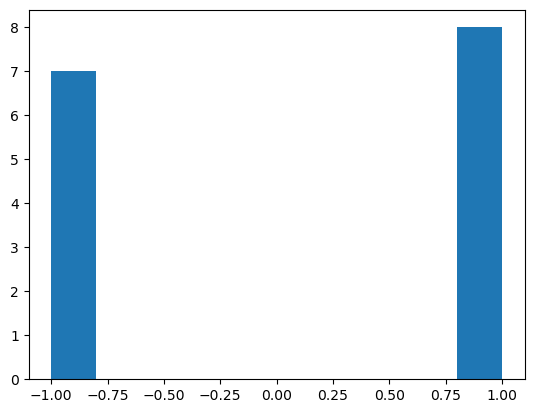

In [22]:
plt.hist([G.nodes[n]['belief_network'].edges[(n,'truck')]['weight'] for n in G.nodes if G.nodes[n]=='democrat'])


(array([13.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

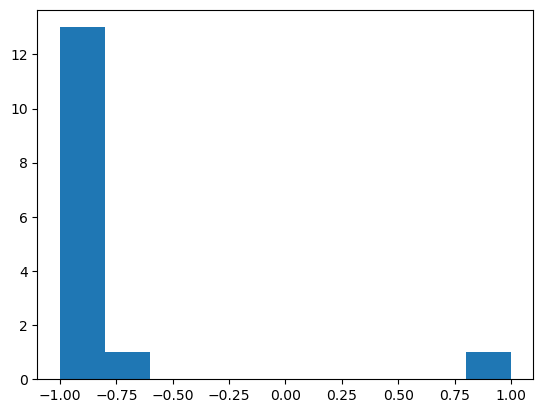

In [25]:
plt.hist([social_G.nodes[n]['belief_network'].edges[(n,'truck')]['weight'] for n in social_G.nodes if communities[n]=='republican'])


In [23]:
node = 12
[social_G.nodes[node]['belief_network'].edges[e] for e in social_G.nodes[node]['belief_network'].edges]

[{'weight': 1},
 {'weight': 1},
 {'weight': 1},
 {'weight': 1},
 {'weight': -1},
 {'weight': 0.7006239277112802},
 {'weight': -0.9757417234391794},
 {'weight': 1},
 {'weight': -1},
 {'weight': 1},
 {'weight': -1},
 {'weight': -3.7449366549445386e-07},
 {'weight': -1},
 {'weight': -0.0015176998759569016},
 {'weight': 1},
 {'weight': -3.038234878738593e-06},
 {'weight': -0.875448217063006},
 {'weight': -1},
 {'weight': 1},
 {'weight': 1.6735670762714976e-05},
 {'weight': -0.5006393006526888},
 {'weight': 1},
 {'weight': -1},
 {'weight': -1},
 {'weight': 0.4072956547166506},
 {'weight': 1},
 {'weight': 1},
 {'weight': -1},
 {'weight': 0.6314591018971215},
 {'weight': 1},
 {'weight': 0.6392369705196617},
 {'weight': 1},
 {'weight': -1},
 {'weight': -1},
 {'weight': 1},
 {'weight': -1},
 {'weight': 1},
 {'weight': -0.26893363921146163},
 {'weight': 0.44299302556499176},
 {'weight': 1},
 {'weight': 0.3046399087596162},
 {'weight': 1},
 {'weight': -0.4768967066970703},
 {'weight': 1},
 {'weig

In [27]:
[social_G.nodes[n]['belief_network'].edges[('democrat', 'truck')]['weight'] for n in social_G.nodes]

[5.117989687675993e-06,
 1.8453220865626682e-07,
 -1.7071735355511001e-06,
 -7.741419040047554e-06,
 4.730107000773653e-06,
 -9.882788164143835e-06,
 4.388214713486539e-06,
 -2.218253853888178e-05,
 -1.339367291981521e-05,
 1.9542962075847303e-05,
 -1.066791440894064e-06,
 1.4762394786233474e-06,
 8.257777258508834e-06,
 -5.641705154275422e-06,
 -6.735483808948753e-06,
 -9.884501107255157e-06,
 5.107200602721698e-06,
 -1.95491772388966e-05,
 1.684714119993804e-06,
 5.33328220380112e-06,
 -1.8572312834124685e-05,
 -1.9575590304114785e-05,
 8.314512852931652e-06,
 -1.1384643889174031e-06,
 -2.540512264557836e-05,
 -1.1420730158990352e-05,
 -6.666178074774073e-06,
 -2.7208702982359666e-06,
 -2.2916922840928115e-06,
 3.6783670132839016e-06]

In [24]:
[social_G.nodes[n]['belief_network'].edges[(n, 'democrat')]['weight'] for n in social_G.nodes if social_G.nodes[n]['belief_network'].has_edge('republican','democrat')]

[-1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1]